### Code to generate the potential location of facility location candidates

In [1]:
import shapely.geometry
import pyproj
import osmnx as ox
import geopandas as gpd
#from mpl_toolkits.basemap import Basemap  #installing basemap along with geopandas/osmnx created big issues in the env
import pandas as pd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
import csv
import os

from shapely.geometry import Polygon
from shapely.geometry import Point

ox.settings.use_cache=True
ox.settings.log_console=True

In [2]:
# define paths
data_path = 'data'
output_path = 'output'

# set parent folder as working directory
os.chdir('..')
os.getcwd()

'c:\\Users\\isaldiviagonzatti\\Downloads\\gitFiles\\MScThesisCode\\FLP'

In [3]:
pyproj.datadir.set_data_dir('C:\\Users\\isaldiviagonzatti\\anaconda3\\envs\\ox\\Library\\share\\proj')
pyproj.datadir.get_data_dir()

'C:\\Users\\isaldiviagonzatti\\anaconda3\\envs\\ox\\Library\\share\\proj'

### Create a regular spaced grid for the area of interest

In [4]:
#solution from https://stackoverflow.com/questions/40342355/how-can-i-generate-a-regular-geographic-grid-using-python

# Set up transformers. 'epsg:32616' is for Costa Rica
to_proxy_transformer = pyproj.Transformer.from_crs('epsg:4326', 'epsg:32616')
to_original_transformer = pyproj.Transformer.from_crs('epsg:32616', 'epsg:4326')

# Create corner locations of rectangle to be transformed to a grid. 
# Defined by limits of area with pineapple fields
                                                     
sw = shapely.geometry.Point((10.09,-85.07)) #south, west
ne = shapely.geometry.Point((11.04, -83.40)) #north, east

stepsize = 5000 # 5 km grid step size


In [5]:
# Project corners to target projection
transformed_sw = to_proxy_transformer.transform(sw.x, sw.y) # Transform sw points to 32616
transformed_ne = to_proxy_transformer.transform(ne.x, ne.y) # .. same for ne

In [6]:
# Iterate over 2D area
# https://stackoverflow.com/questions/40342355/how-can-i-generate-a-regular-geographic-grid-using-python

gridpoints = []
x = transformed_sw[0]
while x < transformed_ne[0]:
    y = transformed_sw[1]
    while y < transformed_ne[1]:
        p = shapely.geometry.Point(to_original_transformer.transform(x, y))
        gridpoints.append(p)
        y += stepsize
    x += stepsize

with open('latloncandid.csv', 'w') as of:
    of.write('lon;lat\n')
    for p in gridpoints:
        of.write('{:f};{:f}\n'.format(p.x, p.y))

In [39]:
#read the created file containing the lat lon points and transform to geodataframe
df = pd.read_csv(os.path.join("latloncandid.csv"), delimiter=';', skiprows=0, low_memory=False)

geometry = [Point(xy) for xy in zip(df['lat'], df['lon'])]
gdf = GeoDataFrame(df, geometry=geometry)   

In [8]:
#import shp of Costa Rica
crShape = gpd.read_file(os.path.join(data_path, "geoCR.geojson"))

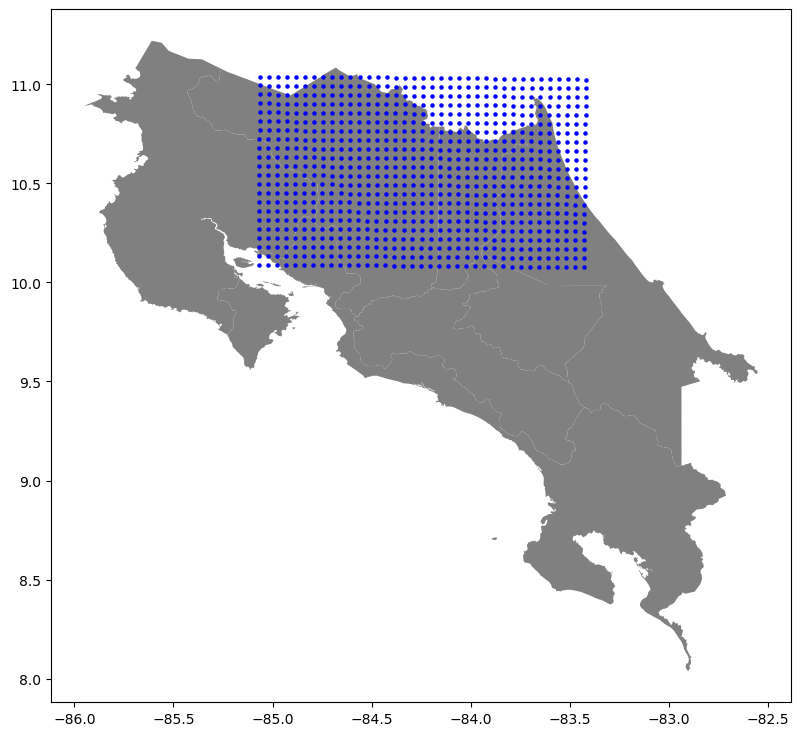

In [9]:
#Plot the generated grid
gdf.plot(ax=crShape.plot(figsize=(15, 9), color='grey'), marker='o', color='blue', markersize=5);

### We are not interested in the grid points outside of the country, so we delete them

In [10]:
gdf = gdf.set_crs('epsg:4326')

In [11]:
candidates = gpd.sjoin(gdf, crShape, how='inner')

<AxesSubplot: >

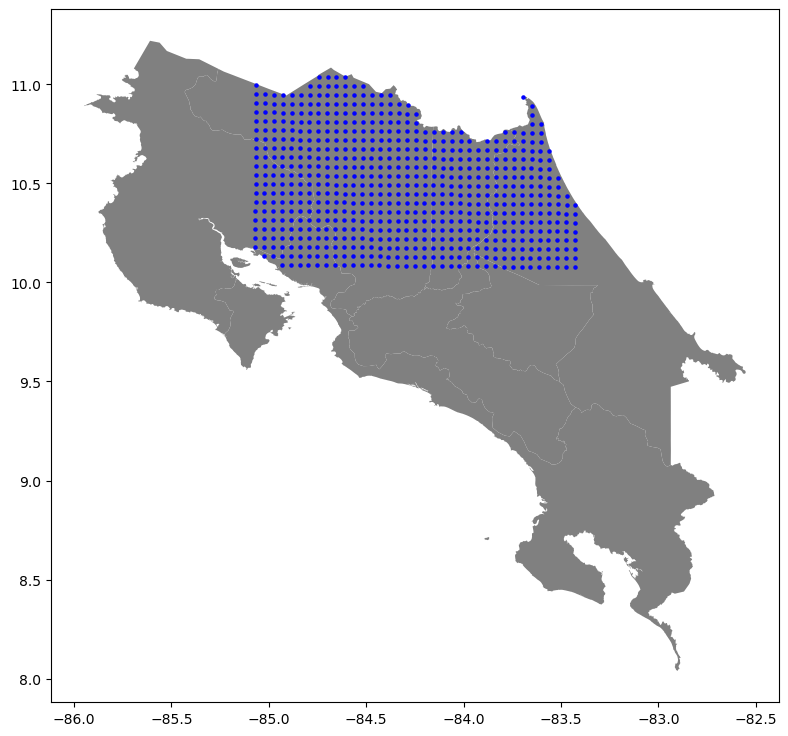

In [12]:
#Plot created grid
candidates.plot(ax=crShape.plot(figsize=(15, 9), color='grey'), marker='o', color='blue', markersize=5)

In [13]:
candidates.to_file(os.path.join(output_path, "candidates.geojson"), driver='GeoJSON')

In [14]:
## path to network
networkFile = os.path.join(output_path, "cr_allPrivate.gpkg") 

In [15]:
#load road network
gdf_nodes = gpd.read_file(networkFile, layer='nodes').set_index('osmid')
gdf_edges = gpd.read_file(networkFile, layer='edges').set_index(['u', 'v', 'key'])
assert gdf_nodes.index.is_unique and gdf_edges.index.is_unique

In [16]:
# convert the node/edge GeoDataFrames to a MultiDiGraph
graph_attrs = {'crs': 'epsg:4326', 'simplified': True}
G = ox.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs)

In [17]:
G_proj = ox.project_graph(G)

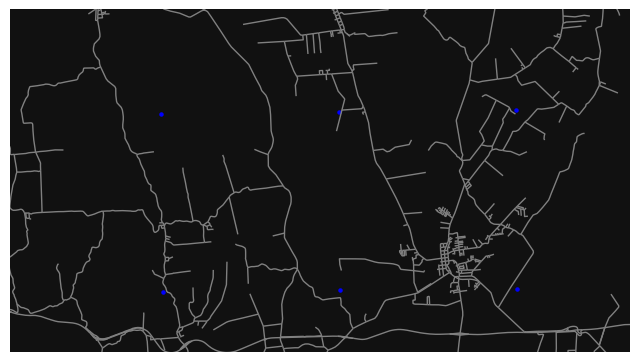

In [18]:
fig, ax = ox.plot_graph(G, edge_color='grey', edge_linewidth=1, node_size=0, show=False, bbox=(10.5167,10.4299,-84.3208,-84.1611))
ax = ax.scatter(candidates['lat'], candidates['lon'], c='b', s=5, zorder=-1)

In [19]:
# project graph and points to same CRS
geom = gpd.points_from_xy(candidates['geometry'].x, candidates['geometry'].y)
gdf = gpd.GeoDataFrame(candidates, crs='epsg:4326').to_crs(G_proj.graph['crs'])

In [20]:
%%time
# calculate nearest edge to each point
neCan = ox.nearest_nodes(G_proj, X=gdf['geometry'].x, Y=gdf['geometry'].y,  return_dist=True)

CPU times: total: 2.41 s
Wall time: 2.52 s


In [21]:
unique_edges=neCan[0]

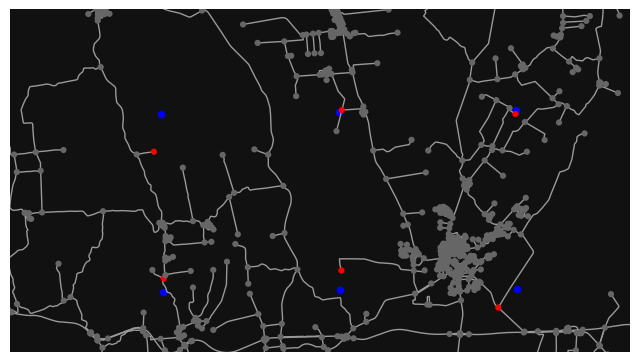

In [22]:
ec = ['r' if e in unique_edges else '#666666' for e in G.nodes]
fig, ax = ox.plot_graph(G, node_color=ec, edge_linewidth=1, node_size=20, show=False, bbox=(10.5167,10.4299,-84.3208,-84.1611))
ax = ax.scatter(candidates['lat'], candidates['lon'], c='blue', s=20, zorder=-1)

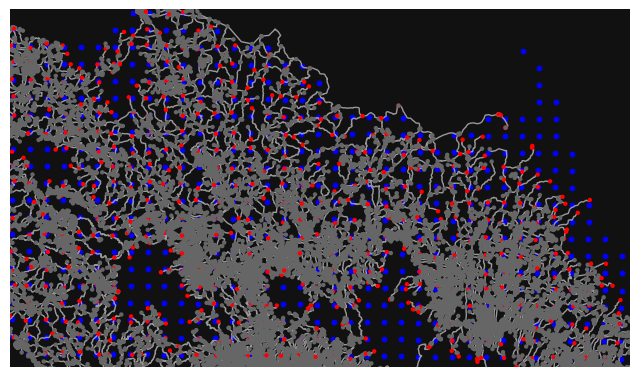

In [23]:
ec = ['r' if e in unique_edges else '#666666' for e in G.nodes]
fig, ax = ox.plot_graph(G, node_color=ec,node_size=10, show=False, bbox=(11.04681261,10.09956058,-83.40407159,-85.07389766))
ax = ax.scatter(candidates['lat'], candidates['lon'], c='blue', s=10, zorder=-5)

In [24]:
with open(os.path.join(output_path, "candiRegGrid.csv"), 'w') as f:
    writer = csv.writer(f , lineterminator='\n')
    writer.writerow(neCan[0])

Note how there are no red dots in some areas, these are national parks without accessible road networks. 

### We can also sample random points in the network

As per the OSMnx documentation: 
Unlike typical spatially uniform random sampling, this method accounts for the graph’s geometry. And unlike equal-length edge segmenting, this method guarantees uniform randomness.

In [25]:
northG = ox.graph.graph_from_bbox(11.2, 10.00, -83, -85.2, network_type = 'drive_service')
G_proj = ox.project_graph(northG)
Gs = ox.utils_graph.get_largest_component(northG, strongly=True)

In [26]:
#save strongly connected network to folder
ox.save_graph_geopackage(Gs, filepath= os.path.join(output_path, "strongNetwork.gpkg"))

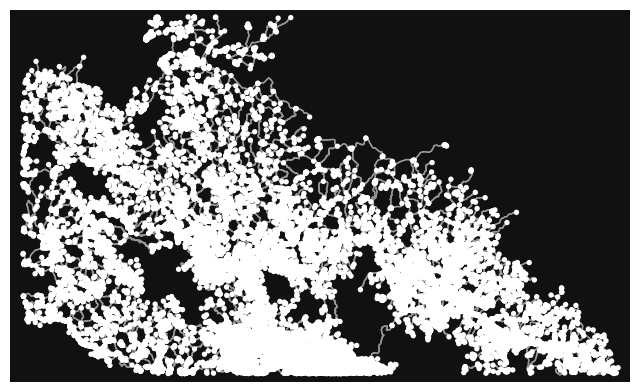

In [27]:
fig, ax = ox.plot_graph(Gs)

In [28]:
%%time
# randomly sample n points spatially-constrained to the network's geometry
points = ox.utils_geo.sample_points(ox.get_undirected(Gs), n=500)
X = points.x.values
Y = points.y.values

CPU times: total: 55 s
Wall time: 56.8 s


c:\Users\isaldiviagonzatti\anaconda3\envs\geoenv\lib\site-packages\osmnx\utils_geo.py:50: UserWarning: Geometry is in a geographic CRS. Results from 'interpolate' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return lines.interpolate(np.random.rand(n), normalized=True)


In [29]:
gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(points))
gdf["id"] = gdf.index

In [30]:
# project graph and points to same CRS
gdf = gpd.GeoDataFrame(gdf, crs='epsg:4326').to_crs(G_proj.graph['crs'])

In [31]:
%%time
# calculate nearest node to each point
neCan1 = ox.nearest_nodes(G_proj, X=gdf['geometry'].x, Y=gdf['geometry'].y, return_dist=True)

CPU times: total: 344 ms
Wall time: 362 ms


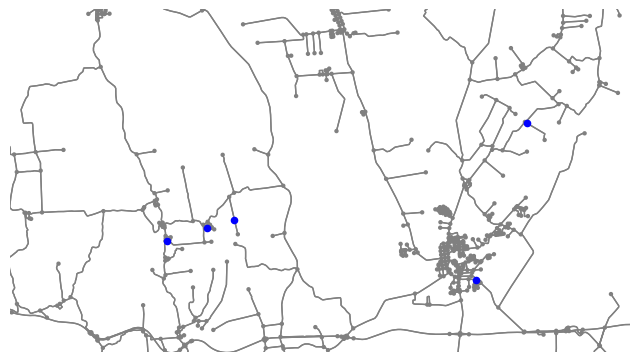

In [32]:
fig, ax = ox.plot_graph(northG, node_color= 'grey', bgcolor='white',  edge_color='grey', edge_linewidth=1, node_size=10, show=False, close=False, bbox=(10.5167,10.4299,-84.3208,-84.1611))
points.plot(ax=ax, markersize = 20, c='blue', zorder=1)
plt.show()

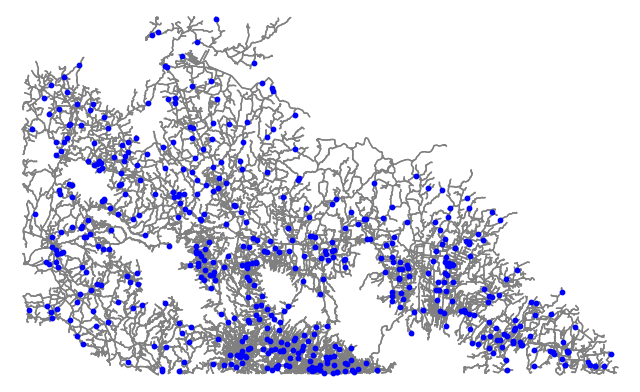

In [38]:
fig, ax = ox.plot_graph(northG, node_color='grey', bgcolor='white',  edge_color='grey', edge_linewidth=1, node_size=1, show=False, close=False)
points.plot(ax=ax, c='blue', zorder=1, markersize = 10)
plt.savefig(os.path.join(output_path,'candidatesNet.pdf'), bbox_inches='tight')

In [34]:
#save new candidates
with open(os.path.join(output_path, "canNetwork.csv"), 'w') as f:
    writer = csv.writer(f , lineterminator='\n')
    for tup in neCan1:
        writer.writerow(tup)

In [35]:
# A longer way to generate the candidates, with a different result, is to get the network from the centroid of the rectangle 
# containing all the PAL fields

# L = [
#      (10.09,-83.40),
#      (10.09,-83.40),
#      ( 11.04,-85.07),
#      ( 11.04,-85.07),
#     ]

# lat = []
# long = []
# for l in L :
#   lat.append(l[0])
#   long.append(l[1])

# latC = sum(lat)/len(lat)
# lonC = sum(long)/len(long)
# print(latC,lonC)

In [36]:
# constrain plot to a bounding box

# bbox = ox.utils_geo.bbox_from_point(point=(latC,lonC), dist=65000)
# fig, ax = ox.plot_graph(G, figsize=(5, 5), bbox=bbox)

In [37]:
# plot with basemap, read comment in cell with packages importing 

# fig = plt.gcf()
# fig.set_size_inches(8, 6.5)

# m = Basemap(projection='lcc', lat_0 = 9., lon_0 = -85,
#     resolution = 'i', area_thresh = 0.1,
#     llcrnrlon=-87, llcrnrlat=9,
#     urcrnrlon=-82, urcrnrlat=13)
 
# m.drawcoastlines()
# m.bluemarble()

# x,y = m(df['lat'],  df['lon'])
# m.scatter(x, y, marker='o', color='Red',s=5)
 
# plt.show()